In [1]:
from wrapper import *
import MahjongPy as mp
import os
import time
import logging
import warnings

import numpy as np
import scipy.io as sio
import torch
import matplotlib.pyplot as plt


from models import VLOG

In [2]:

player_i_hand_start_ind = [0, 63, 69, 75]  # later 3 in oracle_obs
player_i_side_start_ind = [6, 12, 18, 24]
player_i_river_start_ind = [30, 37, 44, 51]

dora_indicator_ind = 58
dora_ind = 59
game_wind_ind = 60
self_wind_ind = 61
latest_tile_ind = 62

aka_tile_ints = [16, 16 + 36, 16 + 36 + 36]
player_obs_width = 63

CHILEFT = 34
CHIMIDDLE = 35
CHIRIGHT = 36
PON = 37
ANKAN = 38
MINKAN = 39
ADDKAN = 40

RIICHI = 41
RON = 42
TSUMO = 43
PUSH = 44
NOOP = 45

In [3]:

UNICODE_TILES = """
    🀇 🀈 🀉 🀊 🀋 🀌 🀍 🀎 🀏 
    🀙 🀚 🀛 🀜 🀝 🀞 🀟 🀠 🀡
    🀐 🀑 🀒 🀓 🀔 🀕 🀖 🀗 🀘
    🀀 🀁 🀂 🀃
    🀆 🀅 🀄
""".split()

EXPLAINS = UNICODE_TILES + ["Chi-Left", "Chi-Middle", "Chi-Right", "Pon", "An-Kan",
           "Min-Kan", "Add-Kan", "Riichi", "Ron", "Tsumo", "Push 99", "Pass"]


def to_unicode_tails(tiles, sort=True):
    unicode_tail_string = ""
    if sort:
        tiles = np.sort(np.array(tiles))

    for tile in tiles:
        unicode_tail_string = unicode_tail_string + UNICODE_TILES[int(tile / 4)]

    return unicode_tail_string

In [4]:
env_test = EnvMahjong3(force_riichi=True, force_win=True)
max_steps = 1000

In [5]:
# agent_test0 = torch.load("C:/code/snake/amlt/vlog_offlinemj_20210724/search_envid_1_beta_1e-05_alpha_1_kldt_10_cqla_10/data/mahjong_VLOG_DDQN_0.model")
# agent_test1 = torch.load("C:/code/snake/amlt/vlog_offlinemj_20210724/search_envid_1_beta_1e-05_alpha_1_kldt_10_cqla_10/data/mahjong_VLOG_DDQN_1.model")
# agent_test2 = torch.load("C:/code/snake/amlt/vlog_offlinemj_20210724/search_envid_1_beta_1e-05_alpha_1_kldt_10_cqla_10/data/mahjong_VLOG_DDQN_2.model")
# agent_test = torch.load("./vlog_offlinemj_20210724/search_envid_1_beta_0_alpha_1_kldt_-1_cqla_100/data/mahjong_VLOG_DDQN_0.model")


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


agent_test0 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_1e-06_alpha_1_kldt_10_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_0.model", map_location=torch.device(device))
agent_test1 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_1e-06_alpha_1_kldt_10_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_1.model", map_location=torch.device(device))
agent_test2 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_1e-06_alpha_1_kldt_10_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_0.model", map_location=torch.device(device))
agent_test3 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_1e-06_alpha_1_kldt_10_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_1.model", map_location=torch.device(device))

# agent_test0 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_-1_alpha_1_kldt_-1_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_0.model", map_location=torch.device(device))
# agent_test1 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_-1_alpha_1_kldt_-1_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_1.model", map_location=torch.device(device))
# agent_test2 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_-1_alpha_1_kldt_-1_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_2.model", map_location=torch.device(device))
# agent_test3 = torch.load("./vlog_offlinemj_bc_20210802/search_beta_-1_alpha_1_kldt_-1_bnt_0_eqn_1_cqla_0/data/mahjong_VLOG_BC_3.model", map_location=torch.device(device))



In [6]:

agents_test = [agent_test0, agent_test1, agent_test2, agent_test3]

for agent in agents_test:
    agent.device = device


In [7]:
full_obs = False

In [8]:
EpiTestRet = 0
steps_taken = 0

game = 0

tsumo_times = 0
houjyu_times = 0

fulu_times = 0

agari_times = 0
agari_scores = []

while game < 10000:
    print("==============================Game {}=============================".format(game))
    # reset each episode
    if game % 10 == 1:
        try:
            print("------------------------- Statistics ----------------------")
            print("自摸率： %f " % (tsumo_times * 100 / agari_times))
            print("放铳率： %f " % (houjyu_times * 100 / game / 4))
            print("和了率： %f " % (agari_times * 100 / game / 4))
            print("副露率： %f " % (fulu_times * 100 / game / 4))
            print("平均打点：%d " % (np.mean(agari_scores) * 100))
        except:
            pass
    try:
        sp = env_test.reset(game % 4, 'east')
        done = False

        for tt in range(max_steps):

            # if curr_pid != 0:
            #     a = valid_actions[np.random.randint(len(valid_actions))]

            valid_actions = env_test.get_valid_actions(nhot=False)

            if len(valid_actions) == 1:
                env_test.t.make_selection(0)

            else:
                curr_pid = env_test.get_curr_player_id()

                action_mask = env_test.get_valid_actions(nhot=True)

                if not full_obs:
                    a = agents_test[curr_pid].select(env_test.get_obs(curr_pid), action_mask, greedy=True)
                else:
                    a = agents_test[curr_pid].select(env_test.get_full_obs(curr_pid), action_mask, greedy=True)

    #                 if a == TSUMO:
    #                     print(env_test.get_full_obs(0)[player_i_river_start_ind[curr_pid]:player_i_river_start_ind[curr_pid] + 7,  int(env_test.latest_tile / 4)])
    #                     plt.pcolor(env_test.get_obs(curr_pid))
    #                     plt.show()

                # if curr_pid == 0 and len(valid_actions) > 1:
                #     print("-------------- Step {}, player {} ----------------".format(tt, curr_pid))
                #     print(env_test.Phases[env_test.t.get_phase()], "Recent Tile:", to_unicode_tails([env_test.latest_tile]))
                #     side_tiles_0 = [st[0] for st in env_test.side_tiles[curr_pid]]
                #     print("手牌: ", to_unicode_tails(env_test.hand_tiles[curr_pid]),
                #           "； 副露：", to_unicode_tails(side_tiles_0))
                #     if a < 34:
                #         agent_selection_str = UNICODE_TILES[a]
                #     else:
                #         agent_selection_str = EXPLAINS[a]
                #
                #     print("Agent选择打: ", agent_selection_str)

                sp, r, done, _ = env_test.step(curr_pid, a)

            steps_taken += 1

            if done or env_test.t.get_phase() == 16:
                payoffs = env_test.get_payoffs()
                # EpiTestRet += payoffs[0]

                print("~~~~~~~~~~~~Result: ", payoffs)

                for uid in range(4):
                    if len(env_test.side_tiles[uid]) >= 3:
                        fulu_times += 1

                if env_test.t.get_remain_tile() > 0 and np.max(payoffs) > 0:  # not 流局
    #                     print(env_test.t.get_remain_tile())
                    result_array = np.array(payoffs)
                    if np.count_nonzero(result_array < 0) == 3:
                        tsumo_times += 1
                    else:
                        houjyu_times += 1

                    agari_times += 1
                    agari_scores.append(np.max(result_array))
                    
                    print("state riichi is", env_test.get_full_obs(np.argmax(result_array))[
                        player_i_river_start_ind[np.argmax(result_array)] + 6, :].sum())

    #                     win_pid = np.argmax(result_array)
    #                     print(env_test.Phases[env_test.t.get_phase()], "Recent Tile:", to_unicode_tails([env_test.latest_tile]))
    #                     side_tiles_0 = [st[0] for st in env_test.side_tiles[win_pid]]
    #                     print("手牌: ", to_unicode_tails(env_test.hand_tiles[win_pid]),
    #                           "； 副露：", to_unicode_tails(side_tiles_0))

                # print(env_test.t.game_log.to_string())
    #                 if np.max(payoffs) > 0:
    #                     plt.pcolor(sp)
    #                     plt.show()
    #                     print(env_test.Phases[env_test.t.get_phase()], "Recent Tile:", to_unicode_tails([env_test.latest_tile]))
    #                     side_tiles_0 = [st[0] for st in env_test.side_tiles[np.argmax(payoffs)]]
    #                     print("手牌: ", to_unicode_tails(env_test.hand_tiles[np.argmax(payoffs)]),
    #                       "； 副露：", to_unicode_tails(side_tiles_0))
                break

    #             if not done and env_test.t.get_phase() == 0:
    #                 shanten_num = np.zeros(4)
    #                 for pid in range(4):
    #                     shanten_num[pid] = shanten.calculate_shanten(TilesConverter.to_34_array(
    #                         env_test.hand_tiles[pid] + [st[0] for st in env_test.side_tiles[pid]]))
    #                 print("向听数:", shanten_num)
        game += 1

    except Exception as e:
        print(e)
        if a < 34:
            agent_selection_str = UNICODE_TILES[a]
        else:
            agent_selection_str = EXPLAINS[a]
        print("Agent选择打: ", a)
        time.sleep(0.1)
        continue

==============================Game 0=============================


C:\Code\mahjong\AI\wrapper.py:669: UserWarning: Can richii, automatically choose to riichi !!
  warnings.warn("Can richii, automatically choose to riichi !!")
C:\Code\mahjong\AI\wrapper.py:621: UserWarning: Can win, automatically choose to win !!
  warnings.warn("Can win, automatically choose to win !!")


~~~~~~~~~~~~Result:  [-40.0, -20.0, 90.0, -20.0]
state riichi is 0.0
==============================Game 1=============================
------------------------- Statistics ----------------------
自摸率： 100.000000 
放铳率： 0.000000 
和了率： 25.000000 
副露率： 0.000000 
平均打点：9000 
~~~~~~~~~~~~Result:  [0.0, 0.0, 0.0, 0.0]
==============================Game 2=============================
~~~~~~~~~~~~Result:  [-20.0, -20.0, -39.0, 89.0]
state riichi is 0.0
==============================Game 3=============================
~~~~~~~~~~~~Result:  [-20.0, -20.0, 100.0, -40.0]
state riichi is 0.0
==============================Game 4=============================
~~~~~~~~~~~~Result:  [15.0, -15.0, -15.0, 15.0]
==============================Game 5=============================
~~~~~~~~~~~~Result:  [-10.0, -10.0, -10.0, 30.0]
==============================Game 6=============================


C:\Code\mahjong\AI\wrapper.py:861: UserWarning: Can win, automatically choose to win !!
  warnings.warn("Can win, automatically choose to win !!")


~~~~~~~~~~~~Result:  [-20.0, 0.0, 0.0, 20.0]
state riichi is 0.0
==============================Game 7=============================
~~~~~~~~~~~~Result:  [0.0, 0.0, 49.0, -39.0]
state riichi is 0.0
==============================Game 8=============================
~~~~~~~~~~~~Result:  [-10.0, -10.0, 30.0, -10.0]
==============================Game 9=============================
~~~~~~~~~~~~Result:  [-15.0, -15.0, 15.0, 15.0]
==============================Game 10=============================
~~~~~~~~~~~~Result:  [0.0, 0.0, 77.0, -77.0]
state riichi is 0.0
==============================Game 11=============================
------------------------- Statistics ----------------------
自摸率： 50.000000 
放铳率： 6.818182 
和了率： 13.636364 
副露率： 29.545455 
平均打点：7083 
~~~~~~~~~~~~Result:  [42.0, -32.0, 0.0, 0.0]
state riichi is 1.0
==============================Game 12=============================
~~~~~~~~~~~~Result:  [0.0, 77.0, -77.0, 0.0]
state riichi is 0.0
==============================Game 13========

In [9]:
to_unicode_tails(env_test.hand_tiles[3])

'🀇🀇🀈🀉🀉🀌🀍🀜🀝🀔🀔🀕🀗'

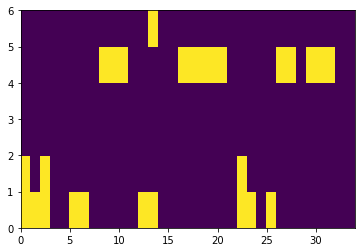

In [10]:
plt.pcolor(env_test.get_obs(3)[:6, :])
plt.show()

In [11]:
env_test.can_riichi_tiles_id

[]

In [12]:
for act in env_test.t.get_self_actions():
    print(act.action)
    print(int(act.correspond_tiles[0].tile))

Action.Play
3
Action.Play
4
Action.Play
4
Action.Play
5
Action.Play
6
Action.Play
13
Action.Play
14
Action.Play
15
Action.Play
24
Action.Play
24
Action.Play
1


In [13]:
env_test.riichi_tile_id

-1

In [14]:
int(env_test.t.get_selected_action_tile().tile)

1

In [15]:
env_test.t.get_response_actions()[0].action

Action.Pass

In [16]:
env_test.t.players[curr_pid].hand.__len__()

10

In [17]:
env_test.Phases[env_test.t.get_phase()]

'GAME_OVER'

In [18]:
env_test.hand_tiles[curr_pid]

[15, 19, 19, 23, 27, 55, 59, 63, 99, 99, 7]

In [19]:
env_test.can_riichi

False

In [20]:
env_test.t.get_self_actions()[0].action

Action.Play

In [21]:
a = set([1,2,3,4,4])

In [22]:
list(a)

[1, 2, 3, 4]

In [23]:
mp.Action.Kakan

Action.Kakan